# Дипомный проект Промышленность

## Описание проекта

Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. Ваша задача — построить модель, которая будет её предсказывать. Заказчик хочет использовать разработанную модель для имитации технологического процесса. Изучите его, прежде чем генерировать новые признаки.

### Описание процесса обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены на крышке ковша.  

Сначала происходит десульфурация — из стали выводят серу и корректируют её химический состав добавлением примесей. Затем сталь легируют — добавляют в неё куски сплава из бункера для сыпучих материалов или порошковую проволоку через специальный трайб-аппарат.  

Прежде чем в первый раз ввести легирующие добавки, специалисты производят химический анализ стали и измеряют её температуру. Потом температуру на несколько минут повышают, уже после этого добавляют легирующие материалы и продувают сталь инертным газом, чтобы перемешать, а затем снова проводят измерения. Такой цикл повторяется до тех пор, пока не будут достигнуты нужный химический состав стали и оптимальная температура плавки.  

Дальше расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов.  

### Описание данных

Данные хранятся в базе данных PostgreSQL. Она состоит из нескольких таблиц:
- steel.data_arc — данные об электродах;
- steel.data_bulk — данные об объёме сыпучих материалов;
- steel.data_bulk_time — данные о времени подачи сыпучих материалов;
- steel.data_gas — данные о продувке сплава газом;
- steel.data_temp — данные об измерениях температуры;
- steel.data_wire — данные об объёме проволочных материалов;
- steel.data_wire_time — данные о времени подачи проволочных материалов.

Таблица ***steel.data_arc***

- key — номер партии;
- BeginHeat — время начала нагрева;
- EndHeat — время окончания нагрева;
- ActivePower — значение активной мощности;
- ReactivePower — значение реактивной мощности.

Таблица ***steel.data_bulk***

- key — номер партии;
- Bulk1 … Bulk15 — объём подаваемого материала.

Таблица ***steel.data_bulk_time***

- key — номер партии;
- Bulk1 … Bulk15 — время подачи материала.

Таблица ***steel.data_gas***

- key — номер партии;
- gas — объём подаваемого газа.

Таблица ***steel.data_temp***

- key — номер партии;
- MesaureTime — время замера;
- Temperature — значение температуры.

Таблица ***steel.data_wire***

- key — номер партии;
- Wire1 … Wire15 — объём подаваемых проволочных материалов.

Таблица ***steel.data_wire_time***

-key — номер партии;
- Wire1 … Wire15 — время подачи проволочных материалов.

Во всех файлах столбец key содержит номер партии. В таблицах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

## Подключение библиотек и выгрузка данных

Подклбчамем необхожимые бибиотеки и заводим глобальные переменные.

In [135]:
from sqlalchemy import create_engine, text
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [136]:
RANDOM_STATE = 5062023
PATH = './data/'

Подлкючаемся к базе данных и оцениваем размеры таблиц.

In [137]:
db_config = {
'user': 'praktikum_student',# имя пользователя
'pwd': 'Sdf4$2;d-d30pp',# пароль
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432,# порт подключения
'db': 'data-science-final'# название базы данных,
}
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)
engine = create_engine(connection_string)

In [138]:
for i in ['steel.data_arc','steel.data_bulk','steel.data_bulk_time','steel.data_gas','steel.data_temp','steel.data_wire','steel.data_wire_time']:
    query = f'''
    SELECT *
    FROM {i}
    '''
    print('-------------------------------------------------------------')
    print(pd.read_sql_query(sql=text(query), con = engine.connect()).info())

-------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   key            14876 non-null  int64  
 1   BeginHeat      14876 non-null  object 
 2   EndHeat        14876 non-null  object 
 3   ActivePower    14876 non-null  float64
 4   ReactivePower  14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
None
-------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 n

Как видим все таблици на месте и они имеют разное количесвто данных и прежде чем их обединять в одну большую, нужно порабоать с каждой по отдельности. 

## Первичный анализ

## data_arc

Начнем с таблицы `data_arc`, выгрузим ее и поработам с каждыйм столбцом.

In [139]:
def get_info(df):
    display(df.info())
    display(df.sample(5))

In [140]:
query = f'''
SELECT *
FROM steel.data_arc
'''
data_arc = pd.read_sql_query(sql=text(query), con = engine.connect())


In [141]:
get_info(data_arc)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   key            14876 non-null  int64  
 1   BeginHeat      14876 non-null  object 
 2   EndHeat        14876 non-null  object 
 3   ActivePower    14876 non-null  float64
 4   ReactivePower  14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

,key,BeginHeat,EndHeat,ActivePower,ReactivePower
9871,2139,17:01:13,17:12:06,3.107820,1.946782
10777,2343,10:28:04,10:30:40,0.518021,0.490093
14271,3102,16:48:24,16:50:38,0.601635,0.413090
2022,435,11:37:49,11:40:54,0.765409,0.495266
10831,2355,20:36:32,20:40:16,1.005125,0.682680


На первый взгляд проблем больших нету, нету пропусков, но лучше перевести столбцы `BeginHeat` и `EndHeat` в формат времени и в итоге получить от них продолжительность нагрева, эта информация важнее.

Что касается мощности то тдумаю нам важнее получить полную мощность потребления, для жтого есть формула  

    sqr(`ActivePower`^2 + `ReactivePower`^2)

воспользуемся ей.

### Столбцы времени.

По скольку столбцы имеют отдин формат, hh:mm:ss проще будем воспользоваться этим и просто написать функцию для пересчета времени, чем по нескольку раз менять формат.

In [142]:
data_arc.loc[0,'EndHeat']

datetime.time(11, 6, 2)

Новая водная, как видно эти столбцы имеют формат `datetime`, по жтому можно просто вычесть один из другого. Так же поскольку это формат `datetime` то и аномалий со временем быть не должно.

In [143]:
def get_seconds(df):
    return ((df['EndHeat'].hour - df['BeginHeat'].hour)*60*60 +
            (df['EndHeat'].minute - df['BeginHeat'].minute)*60 +
            (df['EndHeat'].second - df['BeginHeat'].second))

In [144]:
data_arc['TimeHeat'] = data_arc.apply(get_seconds,axis=1)

In [145]:
get_info(data_arc)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   key            14876 non-null  int64  
 1   BeginHeat      14876 non-null  object 
 2   EndHeat        14876 non-null  object 
 3   ActivePower    14876 non-null  float64
 4   ReactivePower  14876 non-null  float64
 5   TimeHeat       14876 non-null  int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 697.4+ KB


None

,key,BeginHeat,EndHeat,ActivePower,ReactivePower,TimeHeat
6318,1374,00:01:25,00:03:34,0.477216,0.400832,129
11722,2556,02:14:50,02:20:51,1.266593,0.960484,361
461,99,19:49:19,19:53:24,1.158783,0.735780,245
5124,1112,21:34:52,21:38:13,0.693779,0.516580,201
14735,3208,02:02:24,02:08:38,1.700265,1.179449,374


Осталось убедиться что `TimeHeat` не имеет отрицательных значений. Поскольку вогут быть моменты когда, нагрев наичналя в конце дня и заканчивался уже посе полуночи.

In [146]:
data_arc.loc[data_arc['TimeHeat'] <= 0, ['BeginHeat','EndHeat','TimeHeat']]

,BeginHeat,EndHeat,TimeHeat
580,23:59:35,00:01:55,-86260
1170,23:58:57,00:00:07,-86330
1280,23:56:57,00:01:43,-86114
1953,23:58:33,00:01:57,-86196
2952,23:52:55,00:03:13,-85782
3438,23:58:27,00:00:14,-86293
4250,23:58:22,00:01:34,-86208
4752,23:59:04,00:07:07,-85917
5400,23:59:25,00:05:07,-86058
6456,23:56:33,00:01:05,-86128


Как я и предполагал, есть отрицательные значения, из-за оцончания нагрева уже в новом дне. Для решения данной проблемы, нужно просто к этим значениям прибавить полный день в секундах.

In [147]:
data_arc.loc[data_arc['TimeHeat'] <= 0, 'TimeHeat'] = data_arc.loc[data_arc['TimeHeat'] <= 0, 'TimeHeat'] + (24*60*60)

In [148]:
data_arc.loc[data_arc['TimeHeat'] <= 0, 'TimeHeat']

Series([], Name: TimeHeat, dtype: int64)

Теперь все отлично, можно переходить к мощности.

### Мощность.

Как я уже говорил ранее, первое что можно сделать это расчитать полную мощность. Так же можнот добавить отношение активной мощности к реактивной. Кажется этих параметров нам хватит.

Но пержде посмотрим на столбцы, есть ли в них аномалии.

In [149]:
data_arc['ActivePower'].describe()

count    14876.000000
mean         0.670441
std          0.408159
min          0.030002
25%          0.395297
50%          0.555517
75%          0.857034
max          3.731596
Name: ActivePower, dtype: float64

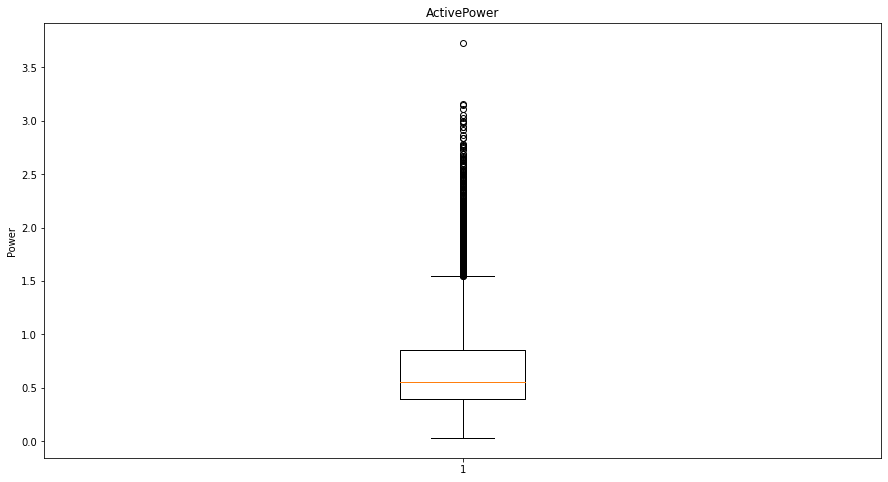

In [150]:
plt.figure(figsize=(15,8))
plt.title('ActivePower')
plt.ylabel("Power")
plt.boxplot(data_arc['ActivePower'])
plt.show()

Как видно 75% значений меньше 0.9, все что выше нельзя считать выбросами, так как мощность нагрева на прямую зависит от состава сплава и его объема, по этому все значения можно остваить.

In [151]:
data_arc['ReactivePower'].describe()

count    14876.000000
mean         0.452592
std          5.878702
min       -715.504924
25%          0.290991
50%          0.415962
75%          0.637371
max          2.676388
Name: ReactivePower, dtype: float64

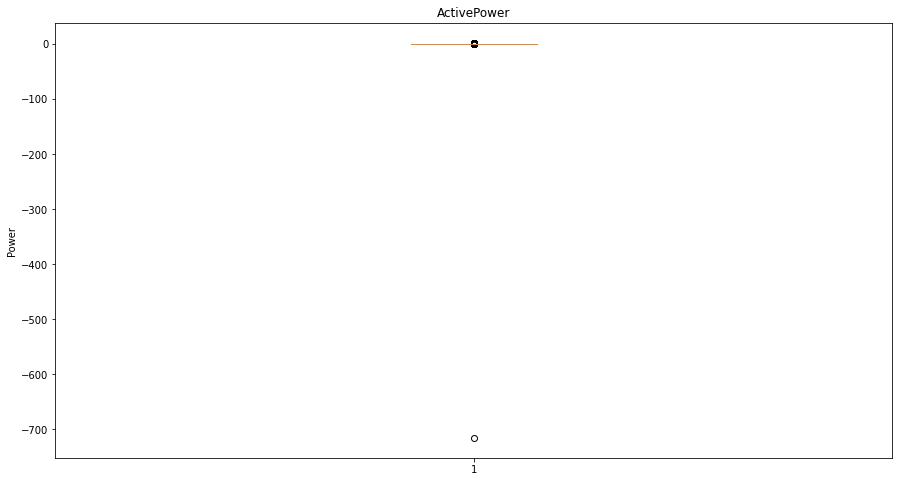

In [152]:
plt.figure(figsize=(15,8))
plt.title('ReactivePower')
plt.ylabel("Power")
plt.boxplot(data_arc['ReactivePower'])
plt.show()

In [153]:
data_arc.loc[data_arc['ReactivePower'] < -700]

,key,BeginHeat,EndHeat,ActivePower,ReactivePower,TimeHeat
9781,2116,00:44:48,00:46:37,0.495782,-715.504924,109


In [154]:
data_arc.loc[data_arc['key'] == 2116]

,key,BeginHeat,EndHeat,ActivePower,ReactivePower,TimeHeat
9779,2116,00:29:52,00:31:54,0.433266,0.306141,122
9780,2116,00:35:50,00:38:05,0.620265,0.408352,135
9781,2116,00:44:48,00:46:37,0.495782,-715.504924,109
9782,2116,00:51:51,00:52:58,0.299368,0.198796,67


У нас есть всего один выброс, его конечно можно заменить, но лучше просто убрать эту партию, потерять 4 значения на 14000, не страшно.

In [155]:
data_arc = data_arc.loc[data_arc['key'] != 2116].reset_index(drop=True)

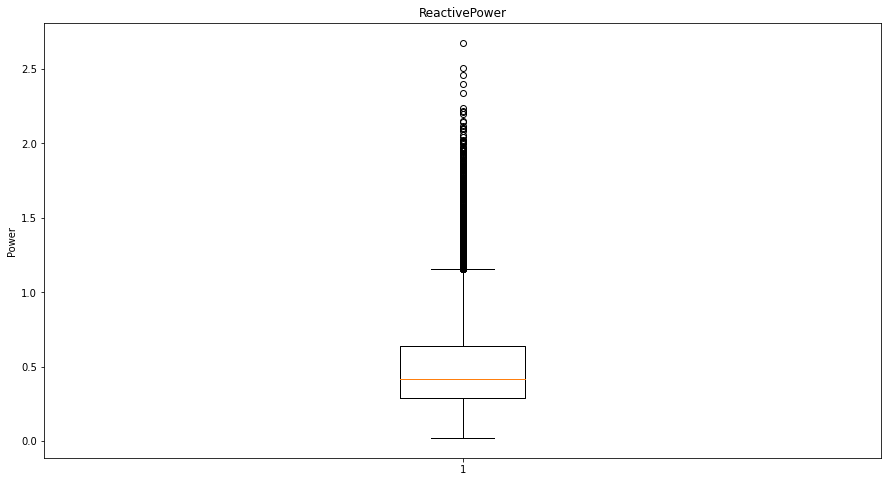

In [156]:
plt.figure(figsize=(15,8))
plt.title('ReactivePower')
plt.ylabel("Power")
plt.boxplot(data_arc['ReactivePower'])
plt.show()

Теперь тут картина как на активной мощности. Теперь можно создавать новые признаки.

In [157]:
data_arc['Power'] = np.sqrt(data_arc['ActivePower']*data_arc['ActivePower'] + 
                              data_arc['ReactivePower']*data_arc['ReactivePower'])

In [159]:
data_arc['RatioPower'] = data_arc['ReactivePower']/data_arc['ActivePower']

In [160]:
get_info(data_arc)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14872 entries, 0 to 14871
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   key            14872 non-null  int64  
 1   BeginHeat      14872 non-null  object 
 2   EndHeat        14872 non-null  object 
 3   ActivePower    14872 non-null  float64
 4   ReactivePower  14872 non-null  float64
 5   TimeHeat       14872 non-null  int64  
 6   Power          14872 non-null  float64
 7   RatioPower     14872 non-null  float64
dtypes: float64(4), int64(2), object(2)
memory usage: 929.6+ KB


None

,key,BeginHeat,EndHeat,ActivePower,ReactivePower,TimeHeat,Power,RatioPower
8753,1903,05:05:11,05:08:24,0.712060,0.492813,193,0.865964,0.692095
6477,1409,03:48:25,03:50:50,0.545774,0.494317,145,0.736355,0.905717
1649,354,17:29:22,17:37:45,2.138216,1.677173,503,2.717512,0.784380
10993,2392,09:15:30,09:17:28,0.417592,0.309103,118,0.519546,0.740204
12322,2676,11:11:44,11:15:06,0.973690,0.575383,202,1.130990,0.590931


Посмотрим, бывают ли моменты когда реактивная мощность больше активной.

In [161]:
data_arc.loc[data_arc['RatioPower'] > 1]

,key,BeginHeat,EndHeat,ActivePower,ReactivePower,TimeHeat,Power,RatioPower
40,10,16:14:58,16:19:15,0.844976,0.853738,257,1.201188,1.010370
144,32,11:40:45,11:43:53,0.560580,0.582463,188,0.808402,1.039035
439,95,16:41:07,16:45:01,0.718904,0.719138,234,1.016849,1.000325
440,95,16:51:58,16:54:16,0.386017,0.457089,138,0.598281,1.184116
524,115,12:26:12,12:27:20,0.158896,0.172457,68,0.234498,1.085339
...,...,...,...,...,...,...,...,...
14759,3216,06:34:08,06:35:21,0.213120,0.239532,73,0.320617,1.123931
14760,3216,06:37:56,06:39:22,0.251099,0.322714,86,0.408895,1.285208
14761,3216,06:42:07,06:43:46,0.328448,0.376886,99,0.499921,1.147477
14762,3216,06:45:12,06:46:38,0.297922,0.345520,86,0.456226,1.159769


У не бльшого количества операций, реактивная мощность больше активной, видимо это зависит от сплава.

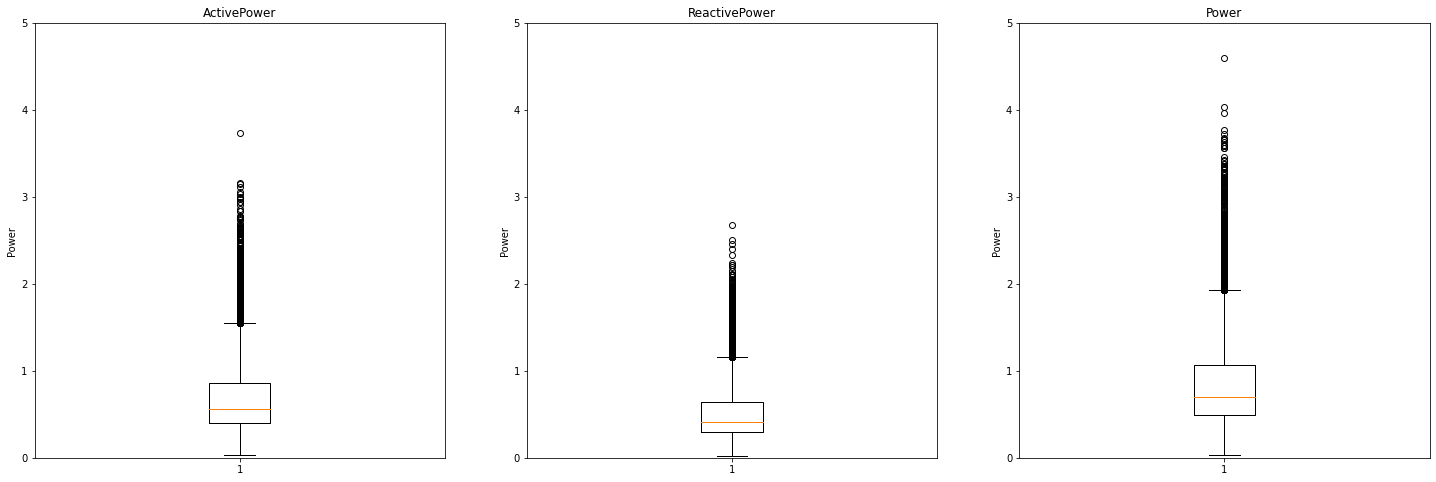

In [169]:
i = 1
fig = plt.figure(figsize=(25, 8))
for column in ['ActivePower','ReactivePower','Power']:
    fig.add_subplot(1,3,i).boxplot(data_arc[column])
    plt.ylim(0,5)
    plt.ylabel("Power")
    plt.title(f"{column}")
    i += 1

Как видно из "коробок с усами" распределение мощности очень похожи, значит и "выбросы" болше 75% не являются выбросами, а просто особенности спалва.

### Удаление столбцов

По скольку время начала и окончания нагревания уже не имеют смысла, можно их спокойно удалить, так как температура нагрева не зависит от времени суток.

In [170]:
data_arc = data_arc.drop(columns=['BeginHeat','EndHeat'], axis=1)

In [171]:
get_info(data_arc)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14872 entries, 0 to 14871
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   key            14872 non-null  int64  
 1   ActivePower    14872 non-null  float64
 2   ReactivePower  14872 non-null  float64
 3   TimeHeat       14872 non-null  int64  
 4   Power          14872 non-null  float64
 5   RatioPower     14872 non-null  float64
dtypes: float64(4), int64(2)
memory usage: 697.2 KB


None

,key,ActivePower,ReactivePower,TimeHeat,Power,RatioPower
13698,2972,0.883809,0.563528,201,1.048181,0.637612
7324,1589,0.192371,0.128701,45,0.231454,0.669026
8200,1781,0.373842,0.276378,87,0.464911,0.739290
10562,2296,0.508371,0.359910,136,0.622878,0.707968
7684,1667,0.332133,0.224418,77,0.400844,0.675686


Дуамаю на этом все, идем к слудующей таблице.

## data_bulk

In [172]:
query = f'''
SELECT *
FROM steel.data_bulk
'''
data_bulk = pd.read_sql_query(sql=text(query), con = engine.connect())

In [173]:
get_info(data_bulk)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
2707,2808,NaN,NaN,NaN,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,158.0,NaN,102.0,108.0
572,601,NaN,NaN,131.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,334.0,NaN,229.0,185.0
2090,2162,46.0,NaN,NaN,186.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,416.0,NaN,246.0,227.0
2431,2523,NaN,NaN,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,148.0,NaN
336,361,10.0,NaN,NaN,105.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,177.0,NaN,165.0,204.0


Как видно тут есть очень много пропусков, эти пропуски скорее всего означают что данный тип материала не подавался. Нужно это проверить.

In [197]:
data_arc.head()

,key,ActivePower,ReactivePower,TimeHeat,Power,RatioPower
0,1,0.976059,0.687084,228,1.193639,0.703937
1,1,0.805607,0.520285,185,0.959010,0.645830
2,1,0.744363,0.498805,172,0.896038,0.670110
3,1,1.659363,1.062669,365,1.970470,0.640408
4,1,0.692755,0.414397,148,0.807239,0.598188


In [188]:
data_arc.pivot_table(index='key',
                     values='Power',
                     aggfunc='count')

,Power
key,
1,5
2,4
3,5
4,4
5,4
...,...
3237,5
3238,3
3239,8


In [196]:
data_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [200]:
data_bulk['Count'] = data_bulk.notna().sum(axis=1)

In [202]:
data_bulk['Count'] == data_arc.pivot_table(index='key',
                     values='Power',
                     aggfunc='count')['Power']

ValueError: Can only compare identically-labeled Series objects